# 4.1 tf.sigmoid() で二値分類を解く


In [1]:
# 4-01-1 改 ステップ関数のグラフを描く
# p.131

import numpy as np

def step_func(x):
    '''
    step function
    
    '''
    return (x > 0).astype(int)

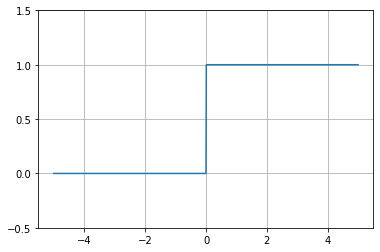

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(-5.0, 5.0, 0.01)
y = step_func(x)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(x, y)

ax.set_ylim(-0.5, 1.5)
ax.set_yticks(np.arange(-0.5, 1.51, 0.5)) # start(-0.5): inclusive, end(1.51): exclusive
ax.grid(True)

plt.show()

In [3]:
# 4-01-3 改 sigmoid function の定義
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

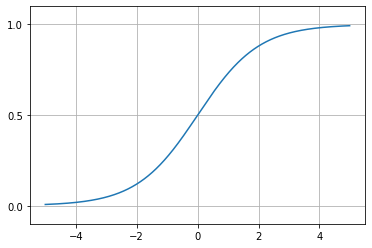

In [4]:
# sigmoid function のグラフを描く
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(-5.0, 5.0, 0.01)
y = sigmoid(x)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(x, y)

ax.set_ylim(-0.1, 1.1)
ax.set_yticks(np.arange(0.0, 1.01, 0.5)) # start(-0.5): inclusive, end(1.51): exclusive
ax.grid(True)

plt.show()

### ロジスティック回帰による二値分類の実装

In [5]:
# 4-01-4 訓練データの生成
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(123)

input_dim = 2
n = 500

x1 = np.random.randn(n, input_dim) + np.array([3, 2]) # (3,2)の周りに500個の点
x2 = np.random.randn(n, input_dim) + np.array([7, 6]) # (7,6)の周りに500個の点

t1 = np.array([[0] for i in range(n)])  # x1のラベル 0
t2 = np.array([[1] for i in range(n)])  # x2のラベル 1

print(x1.shape)
print(t1.shape)

x = np.concatenate((x1, x2), axis=0) # x1, x2 を縦方向に連結
t = np.concatenate((t1, t2), axis=0) # t1, t2 を縦方向に連結

x = x.astype('float32')
t = t.astype('float32')

print(x.shape)
print(t.shape)

x_train, x_validation, t_train, t_validation = train_test_split(x, t, test_size=0.2) # 学習用0.8, 検証用0.2

(500, 2)
(500, 1)
(1000, 2)
(1000, 1)


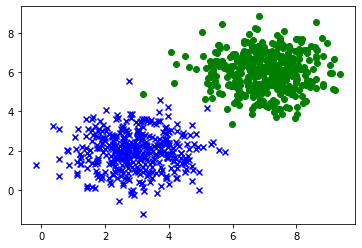

In [6]:
# 4-01-5 改 訓練データをプロット
# 本ではxを全部プロットするコードを載せているが、以下では訓練データtrain_xだけをプロットする。
%matplotlib inline
import matplotlib.pyplot as plt

x_train_t0 = x_train[t_train[:,0] == 0]
x_train_t1 = x_train[t_train[:,0] == 1]

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x_train_t0[:,0], x_train_t0[:, 1], marker='x', color='blue')
ax.scatter(x_train_t1[:,0], x_train_t1[:, 1], marker='o', color='green')

plt.show()

In [7]:
# 4-01-6 モデルを生成するクラスの定義
# p.154
import tensorflow as tf

class MLP(tf.keras.Model):
    '''
    Multilayer Perceptron
    '''
    def __init__(self, hidden_dim, output_dim):
        '''
        Parameters:
          hidden_dim(int): unit number of hidden layer
          output_dim(int): unit number of output layer
        '''
        super().__init__()
        self.l1 = tf.keras.layers.Dense(hidden_dim, activation='sigmoid')
        self.l2 = tf.keras.layers.Dense(output_dim, activation='sigmoid')
        
    def call(self, x):
        '''
        MLPのインスタンスからコールバックされる関数'''
        h = self.l1(x)
        y = self.l2(h)
        return y

In [8]:
# 4-01-7 クロスエントロピー誤差を求める関数の定義
#p.156

bce = tf.keras.losses.BinaryCrossentropy()

def loss(t, y):
    '''
    Parameters:
      t(ndarray(float32)): 正解ラベル
      y(ndarray(float32)): 予測値
    '''
    return bce(t, y)

In [9]:
# 4-01-8 バックプロパゲーション
# p.157

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

@tf.function
def train_step(x, t):
    '''
    Update parameters with backpropagation
    
    Parameters:
      x (ndarray(float32)): training data
      t (ndarray(float32)): label
      
    Returns:
       crossentropy_error
    '''
    
    with tf.GradientTape() as tape:
        outputs = model(x)                  # modelは外部変数
        tmp_loss = loss(t, outputs)
    # tapeに記録された情報を元に勾配を計算する
    grads = tape.gradient(tmp_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return tmp_loss

In [10]:
# 4-01-9 バックプロパゲーションによるパラメータの更新
# p.159

from sklearn.utils import shuffle

epochs = 50
batch_size = 32
steps = x_train.shape[0] // batch_size

model = MLP(2, 1)

for epoch in range(epochs):
    epoch_loss = 0
    x_, t_ = shuffle(x_train, t_train, random_state=0)
    for step in range(steps):
        #start = steps * step   # !!! bug?
        start = batch_size * step   # bug fix by nitta 2021/02/26
        end = start + batch_size
        tmp_loss = train_step(x_[start:end], t_[start:end])
    epoch_loss = tmp_loss.numpy()
    
    if (epoch + 1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss: {epoch_loss:.6f}')
        
model.summary()

epoch: 10, loss: 0.619188
epoch: 20, loss: 0.395204
epoch: 30, loss: 0.239842
epoch: 40, loss: 0.155677
epoch: 50, loss: 0.111686
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  6         
_________________________________________________________________
dense_1 (Dense)              multiple                  3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 4-01-10 検証データで損失と精度を測定する
t_preds = model(x_validation)
bn_acc = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
bn_acc.update_state(t_validation, t_preds)
validation_acc = bn_acc.result().numpy()
validation_loss = loss(t_validation, t_preds)
print(f'val_loss: {validation_loss:.6f}  val_acc: {validation_acc:.6f}')

val_loss: 0.095599  val_acc: 0.995000


## Keras (tensorflow.keras) によるプログラミング


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

model2 = Sequential()
model2.add(Dense(2, activation='sigmoid'))
model2.add(Dense(1, activation='sigmoid'))

optimizer2 = optimizers.SGD(learning_rate=0.1)

model2.compile(optimizer = optimizer2,
             loss='binary_crossentropy',
             metrics = ['accuracy'])

In [13]:
history = model2.fit(x_train,
                   t_train,
                   epochs=100,
                   batch_size=32,
                   verbose=1,
                   validation_data=(x_validation, t_validation)
                   )

model2.summary()

Epoch 1/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5263 - val_loss: 0.6814 - val_accuracy: 0.5500
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.5738 - val_loss: 0.6611 - val_accuracy: 0.6250
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6532 - accuracy: 0.7000 - val_loss: 0.6536 - val_accuracy: 0.6300
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6455 - accuracy: 0.6875 - val_loss: 0.6438 - val_accuracy: 0.7050
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6370 - accuracy: 0.7600 - val_loss: 0.6351 - val_accuracy: 0.7350
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6280 - accuracy: 0.7750 - val_loss: 0.6250 - val_accuracy: 0.7800
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6172 - accuracy: 0.8213 - val_loss: 0.6151 - val_accuracy: 0.7550
Epoch 8/100
2

Epoch 59/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - accuracy: 0.9937 - val_loss: 0.0513 - val_accuracy: 1.0000
Epoch 60/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - accuracy: 0.9950 - val_loss: 0.0526 - val_accuracy: 0.9950
Epoch 61/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9975 - val_loss: 0.0503 - val_accuracy: 0.9950
Epoch 62/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - accuracy: 0.9962 - val_loss: 0.0504 - val_accuracy: 0.9950
Epoch 63/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - accuracy: 0.9950 - val_loss: 0.0478 - val_accuracy: 1.0000
Epoch 64/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.9975 - val_loss: 0.0481 - val_accuracy: 0.9950
Epoch 65/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - accuracy: 0.9975 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 

## [自習]　Keras のFunctional API で記述する。

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

input = tf.keras.Input(shape=(2), dtype='float32')
H = Dense(2, activation='sigmoid')(input)
H = Dense(1, activation='sigmoid')(H)
model3 = tf.keras.Model(inputs=input, outputs=H)

optimizer3 = optimizers.SGD(learning_rate=0.1)

model3.compile(optimizer = optimizer3,
               loss='binary_crossentropy',
               metrics = ['accuracy'])

In [15]:
history = model3.fit(x_train,
                     t_train,
                     epochs=100,
                     batch_size=32,
                     verbose=1,
                     validation_data=(x_validation, t_validation)
                   )

model3.summary()

Epoch 1/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6595 - accuracy: 0.7437 - val_loss: 0.6504 - val_accuracy: 0.5750
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6391 - accuracy: 0.7075 - val_loss: 0.6322 - val_accuracy: 0.7950
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6218 - accuracy: 0.8675 - val_loss: 0.6138 - val_accuracy: 0.8650
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.9375 - val_loss: 0.5959 - val_accuracy: 0.8800
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5852 - accuracy: 0.9187 - val_loss: 0.5749 - val_accuracy: 0.9100
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5640 - accuracy: 0.9112 - val_loss: 0.5525 - val_accuracy: 0.9550
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5435 - accuracy: 0.9425 - val_loss: 0.5293 - val_accuracy: 0.9250
Epoch 8/100
2

Epoch 59/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.9950 - val_loss: 0.0513 - val_accuracy: 0.9950
Epoch 60/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9950 - val_loss: 0.0474 - val_accuracy: 1.0000
Epoch 61/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - accuracy: 0.9950 - val_loss: 0.0470 - val_accuracy: 1.0000
Epoch 62/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9962 - val_loss: 0.0469 - val_accuracy: 0.9950
Epoch 63/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9962 - val_loss: 0.0451 - val_accuracy: 1.0000
Epoch 64/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.9950 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 65/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9950 - val_loss: 0.0427 - val_accuracy: 1.0000
Epoch 

In [16]:
# 予測してみる(3個)。 0.5以上が1, 0.5未満が0を意味する。
model2.predict([[5,6],[2,4], [7,8]])

array([[0.9552352 ],
       [0.03380454],
       [0.99154574]], dtype=float32)

In [17]:
n_grid = 100
px = np.linspace(-1, 10, n_grid)
py = np.linspace(-1, 10, n_grid)
xv, yv = np.meshgrid(px, py)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

predicts = model2.predict(z_grid)
print(len(predicts))
    
idx0 = [i for i in range(len(z_grid)) if predicts[i] < 0.5]
idx1 = [i for i in range(len(z_grid)) if predicts[i] >= 0.5]

10000


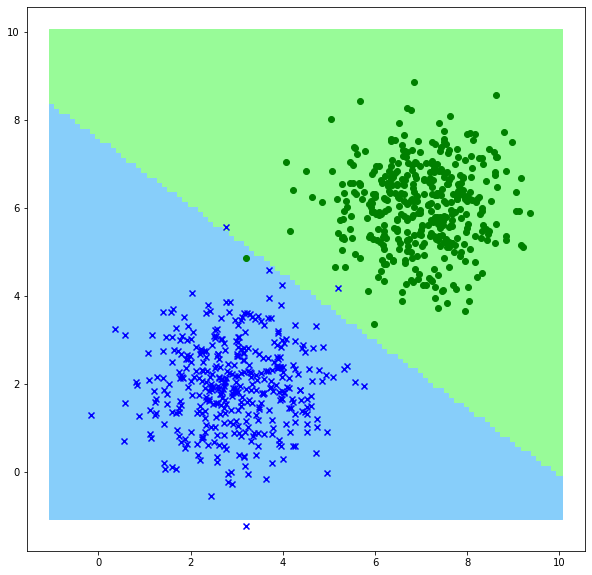

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,10))

# background
ax.scatter(z_grid[idx0,0], z_grid[idx0,1], marker='s', color='lightskyblue')
ax.scatter(z_grid[idx1,0], z_grid[idx1,1], marker='s', color='palegreen')

# training data
ax.scatter(x_train_t0[:,0], x_train_t0[:, 1], marker='x', color='blue')
ax.scatter(x_train_t1[:,0], x_train_t1[:, 1], marker='o', color='green')

plt.show()